# Customer Segmentation Marketing

## Introducción

Tenemos una base de datos de clientes de una empresa de educación, con información sobre:

Minutos de uso de la plataforma desde que se unió al programa

CLV (Customer Lifetime Value) de cada cliente que es el monto total que logró generar el cliente desde que se unió al programa.

Región de donde proviene el estudiante 0: USA, Canadá, UK, Australia, 1: Oeste de europa, 2: Resto del mundo

Canal : 1 Google, 2 Facebook, 3 Youtube, 4 LinkedIn, 5 Twitter, 6 Instagram, 7 Friend, 8 Other.

*Los objetivos generales son*:

* ¿En que medida influye el canal de adquisición en los resultados de aprendizaje de los alumnos?
* ¿Hay alguna ubicación geográfica de donde la mayoría de los estudiantes descubran la plataforma?

Este proyecto profundiza la diversidad del comportamiento de los clientes e indenfitica los segmentos de clientes que son más valiosos para la empresa.

In [90]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [91]:
data = pd.read_csv('./Data/customer_segmentation_data.csv')

In [92]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   minutes_watched  3725 non-null   float64
 1   CLV              3834 non-null   float64
 2   region           3834 non-null   int64  
 3   channel          3834 non-null   int64  
dtypes: float64(2), int64(2)
memory usage: 119.9 KB


Tenemos 3834 entradas y 4 columnas en total de las cuales los minutos de uso y el CLV son variables numéricas y la región y el canal son variables categóricas.

In [93]:
data.head()

,minutes_watched,CLV,region,channel
0,3197.0,205.42,2,4
1,63.0,149.99,0,1
2,605.0,119.00,2,2
3,20.0,240.00,2,4
4,245.0,184.36,1,4


In [94]:
data.isna().sum().sort_values(ascending=False)

minutes_watched    109
CLV                  0
region               0
channel              0
dtype: int64

Los minutos de uso tienen 109 datos faltantes de los 3834, veamos cuáles son estas filas.

In [95]:
data[data['minutes_watched'].isna()]

,minutes_watched,CLV,region,channel
215,NaN,300.06,0,4
368,NaN,43.82,1,3
470,NaN,150.28,0,6
545,NaN,149.99,2,3
764,NaN,62.58,2,6
...,...,...,...,...
3809,NaN,79.00,0,3
3813,NaN,94.80,2,4
3816,NaN,94.01,1,4
3822,NaN,79.00,0,3


Vemos que a pesar de que hay datos faltantes en la columna de minutos de uso, no hay datos faltantes en las otras columnas. En particular que no haya datos faltantes en las columnas de CLV nos indica que quizás no son cursos comprados sino otro tipo de contenido que se consume en la plataforma.

Vamos a imputar 0 a los datos faltantes de minutos de uso con esta hipótesis en mente.

In [96]:
data = data.fillna(0)

In [97]:
data.isna().sum().sort_values(ascending=False)

minutes_watched    0
CLV                0
region             0
channel            0
dtype: int64

## EDA

### Variables numéricas
Comencemos con un análisis de las variables numéricas, es decir de los minutos de uso y el CLV.

In [98]:
data.describe()

,minutes_watched,CLV,region,channel
count,3834.000000,3834.000000,3834.000000,3834.000000
mean,1916.028169,118.383920,1.167188,3.870370
std,7303.052488,70.471274,0.923055,2.191972
min,0.000000,0.000000,0.000000,1.000000
25%,137.000000,62.580000,0.000000,2.000000
50%,480.500000,119.000000,2.000000,3.000000
75%,1464.000000,149.990000,2.000000,6.000000
max,288508.000000,626.400000,2.000000,8.000000


Para ver mejor estas variables vamos a verlas gráficamente.

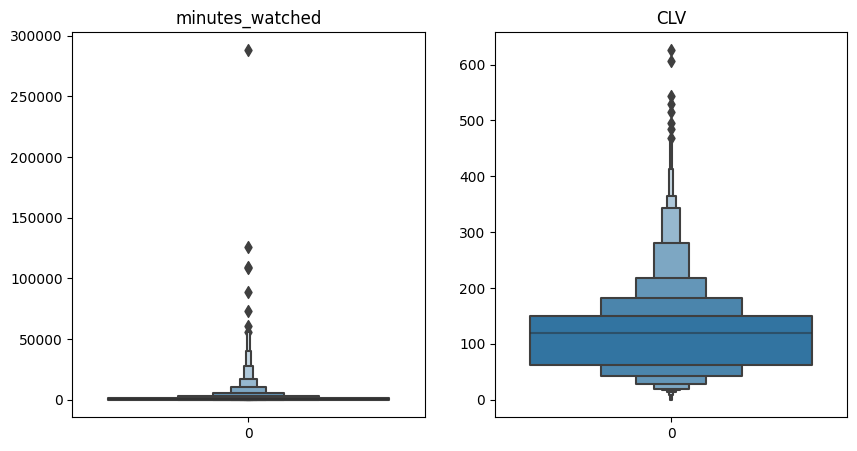

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.boxenplot(data['minutes_watched'], ax=ax[0])
ax[0].set_title('minutes_watched')

sns.boxenplot(data['CLV'], ax=ax[1])
ax[1].set_title('CLV')

plt.show()

Veamos la distribución normalizada de los minutos de uso y el CLV.

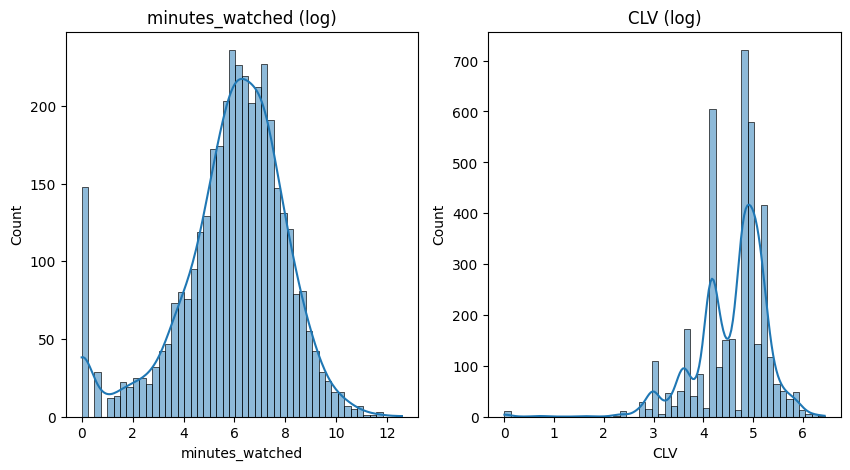

In [100]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(np.log1p(data['minutes_watched']), bins=50, kde=True, ax=ax[0])
ax[0].set_title('minutes_watched (log)')

sns.histplot(np.log1p(data['CLV']), bins=50, kde=True, ax=ax[1])
ax[1].set_title('CLV (log)')

plt.show()

Como vemos ambas distribuciones son multimodales, es decir, tienen más de un pico. Esto podría indicar distintos grupos de clientes. Dado que estos métodos de clustering son sensibles a outliers, vamos a quitarlos de los datos usando el Z-score. Este nos dice que tan lejos está un punto de la media en términos de desviaciones estándar. Vamos a quitar los puntos que estén a más de 4 desviaciones estándar de la media.

In [101]:
from scipy import stats

# Tenemos que normalizar los datos para que tengan una distribución normal
num_data = data[['minutes_watched', 'CLV']]

# Removemos los outliers
z_scores = stats.zscore(num_data)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 4).all(axis=1)
data = data[filtered_entries]

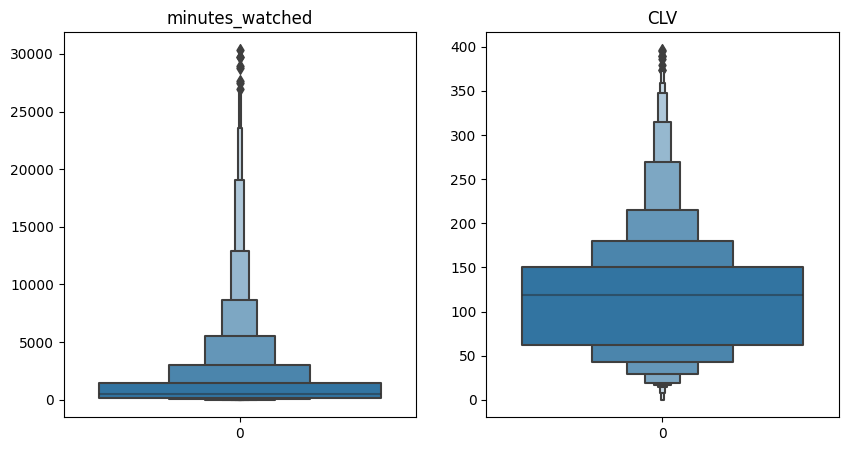

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.boxenplot(data['minutes_watched'], ax=ax[0])
ax[0].set_title('minutes_watched')

sns.boxenplot(data['CLV'], ax=ax[1])
ax[1].set_title('CLV')

plt.show()

### Variables categóricas
Ahora vamos a ver las variables categóricas, es decir, la región y el canal. Comenzamos haciendo histogramas de ambas variables.

In [103]:
label_region = ['USA-Canada-UK-Australia','EUW', 'RestOfWorld']
label_channel = ['Google', 'Facebook', 'Youtube', 'LinkedIn', 'Twitter', 'Instagram', 'Friend', 'Other']

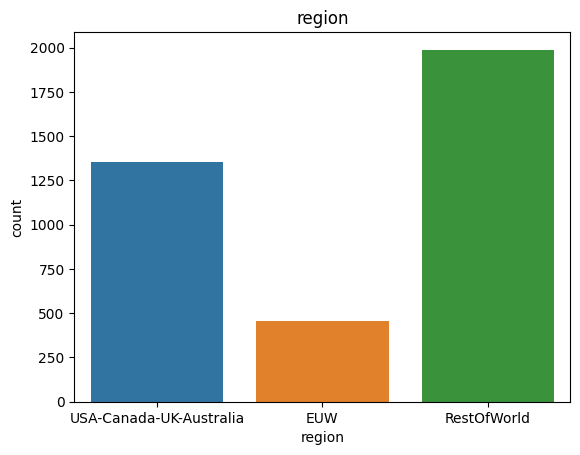

In [104]:
sns.countplot(data = data, x = 'region')
plt.xticks(ticks = [0, 1, 2], labels = label_region)
plt.title('region')
plt.show()

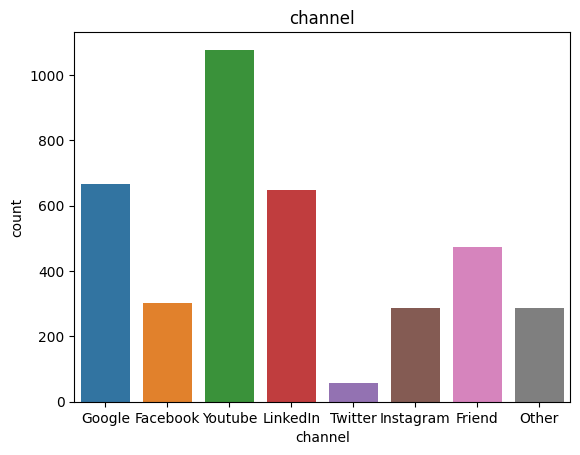

In [105]:
sns.countplot(data = data, x = 'channel')
plt.xticks(ticks = [0, 1, 2, 3, 4, 5, 6, 7], labels = label_channel)
plt.title('channel')
plt.show()

Vemos que la región resto del mundo es desde donde mas llegan los estudiantes a la plataforma. En cuanto al canal, la mayoría de los estudiantes llegan a través de Youtube.

Veamos las correlaciones entre todas las variables utilizando un heatmap. Además separamos los datos en dummy variables para poder tener una información más clara de las correlaciones.

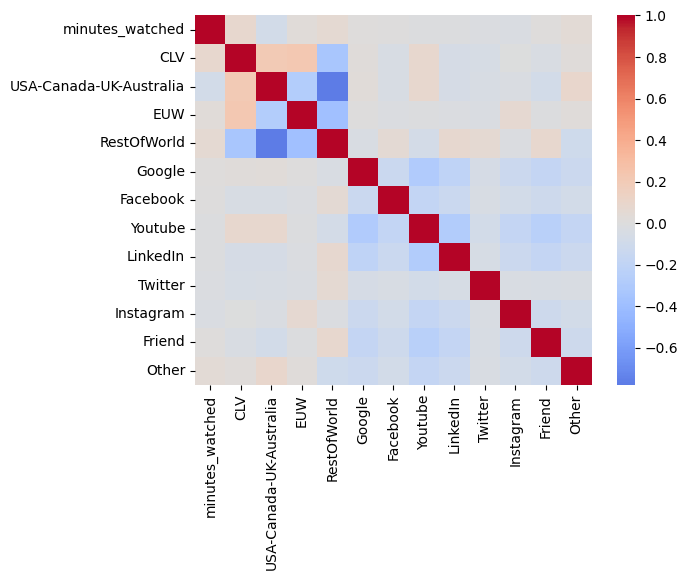

In [106]:
data_dummies = pd.get_dummies(data, columns=['region', 'channel'], drop_first = False)
data_dummies.columns = ['minutes_watched', 'CLV'] + label_region + label_channel
sns.heatmap(data_dummies.corr(), cmap='coolwarm', center=0, annot=False)
plt.show()

Por el mapa de calor nos damos cuenta de que no hay correlaciones fuertes entre las variables. Para hacer un clustering de los clientes según sus características y ver si hay algún patrón en los datos que tenga que ver con la región o el canal de adquisición, vamos a utilizar el método de K-means.

Antes de hacer el clustering vamos a pasar los datos de minutos mirados a escala logarítimca ya que veíamos claramente una distribución mas sencilla y además vamos a estandarizar los datos.

In [107]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

data['log_minutes_watched'] = np.log1p(data['minutes_watched'])

originalMinutes = data['minutes_watched'].copy()
originalCLV = data['CLV'].copy()

data.drop(columns=['minutes_watched'], inplace=True)

data[['log_minutes_watched', 'CLV']] = scaler.fit_transform(data[['log_minutes_watched', 'CLV']])

In [108]:
data.describe()

,CLV,region,channel,log_minutes_watched
count,3797.000000,3797.000000,3797.000000,3797.000000
mean,0.293947,1.167501,3.874638,0.569512
std,0.165990,0.922935,2.193746,0.203098
min,0.000000,0.000000,1.000000,0.000000
25%,0.157839,0.000000,2.000000,0.475995
50%,0.300141,2.000000,3.000000,0.597173
75%,0.378304,2.000000,6.000000,0.704297
max,1.000000,2.000000,8.000000,1.000000


## Implementación de algorithmos de clustering

### K-means

Vamos a utilizar el método de K-means para hacer un clustering de los clientes. Para esto vamos a utilizar la librería de sklearn.

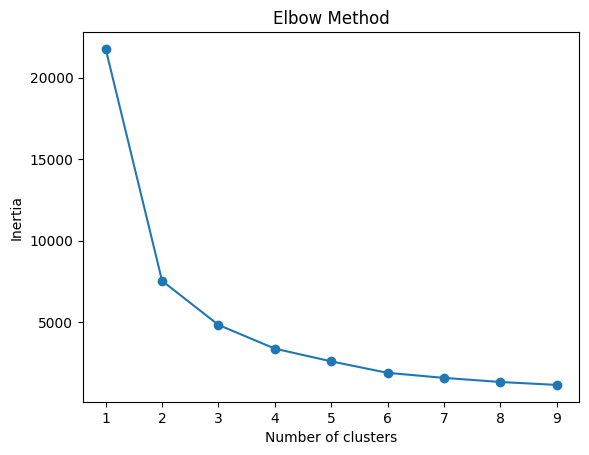

In [109]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Primero tenemos que determinar cual es número de clusters óptimo para nuestro modelo

sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(data)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 10), sse, marker='o')
plt.title('Elbow Method')
plt.xticks(range(1, 10))
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Probé ajustando, los dummy pero funciona mejor sin hacer el one hot encoder. Basandonos en el método del codo tenemos que el número óptimo de clusters sería 4.

In [110]:
k = 4

# Funciones para el análisis de los clusters creados

def clustersData(data, k):
    data_c = []
    for i in range(k):
        data_c.append(data[data['cluster'] == i])
    
    return data_c

def clusterAnalysis(data_c, k):
    fig, ax = plt.subplots(1, k, figsize=(20, 5))
    ax = ax.ravel()

    for i, cluster in enumerate(data_c):
        sns.histplot(cluster['CLV'], bins=50, kde=True, ax=ax[i])
        ax[i].set_title(f'Cluster {i}')

    plt.show()

    fig, ax = plt.subplots(1, k, figsize=(20, 5))

    ax = ax.ravel()

    for i, cluster in enumerate(data_c):
        sns.histplot(cluster['minutes_watched'], bins=50, kde=True, ax=ax[i])
        ax[i].set_title(f'Cluster {i}')

    plt.show()

    fig, ax = plt.subplots(1, k, figsize=(20, 5))

    ax = ax.ravel()

    for i, cluster in enumerate(data_c):
        sns.countplot(data = cluster, x = 'region', ax = ax[i])
        ax[i].set_title(f'Cluster {i}')

    plt.show()

    fig, ax = plt.subplots(1, k, figsize=(20, 5))

    ax = ax.ravel()

    for i, cluster in enumerate(data_c):
        sns.countplot(data = cluster, x = 'channel', ax = ax[i])
        ax[i].set_title(f'Cluster {i}')

    plt.show()

In [111]:
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
data['cluster'] = kmeans.fit_predict(data)

# Calculamos el silhouette score
silhouetteavg = silhouette_score(data, data['cluster'])
print(f'Silhouette Score: {silhouetteavg}')

Silhouette Score: 0.6248664128223685


Tenemos un valor medio de métrica de silhouette lo cual nos indica que los clusters están bien definidos, puesto que esta métrica mide que tan similares son los puntos dentro de un cluster y qué tan diferentes son los puntos de distintos clusters.

Veamos la distribución de los clusters

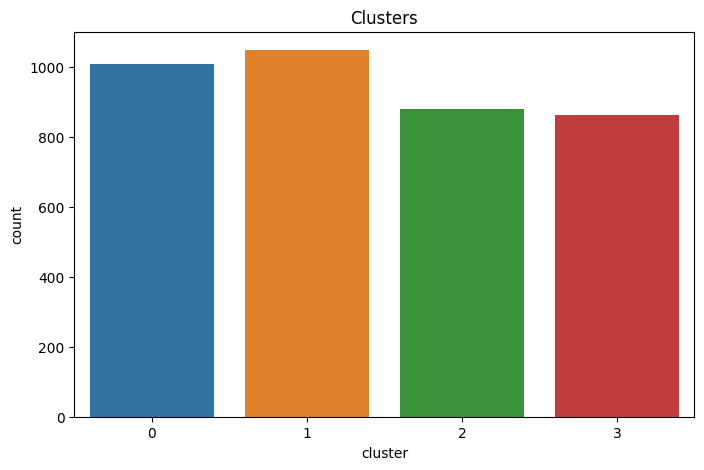

In [112]:
plt.figure(figsize=(8, 5))
pl = sns.countplot(x=data['cluster'])
pl.set_title('Clusters')
plt.show()

Para los graficos vamos a usar los datos sin escalar para poder ver los valores reales.

In [113]:
data['minutes_watched'] = originalMinutes
data['CLV'] = originalCLV

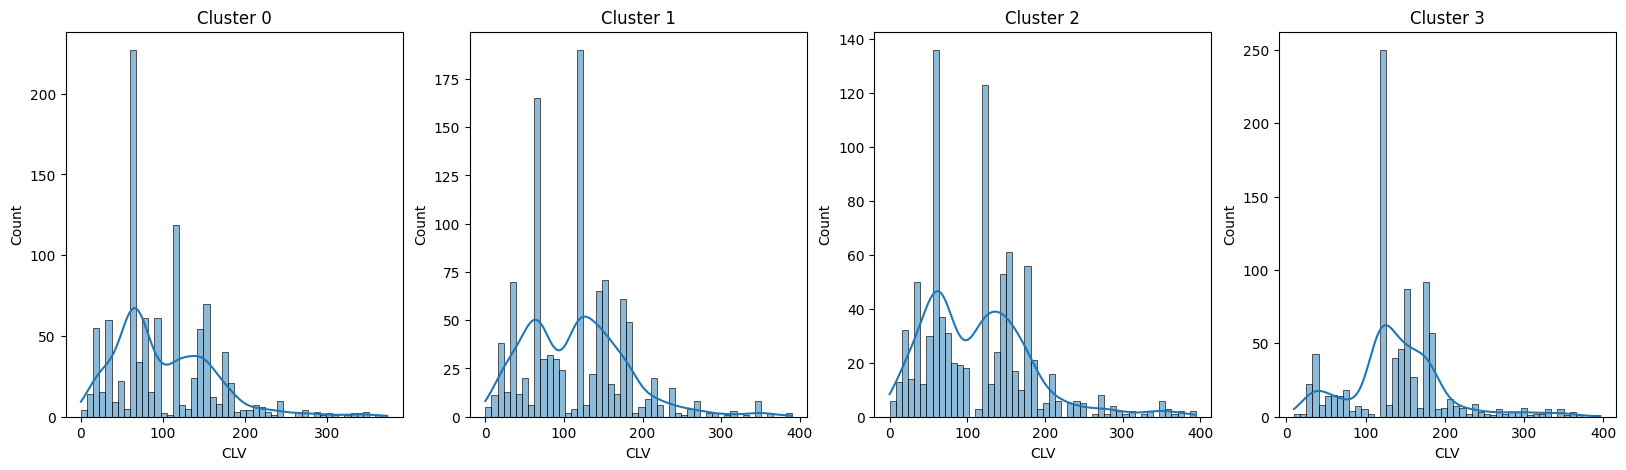

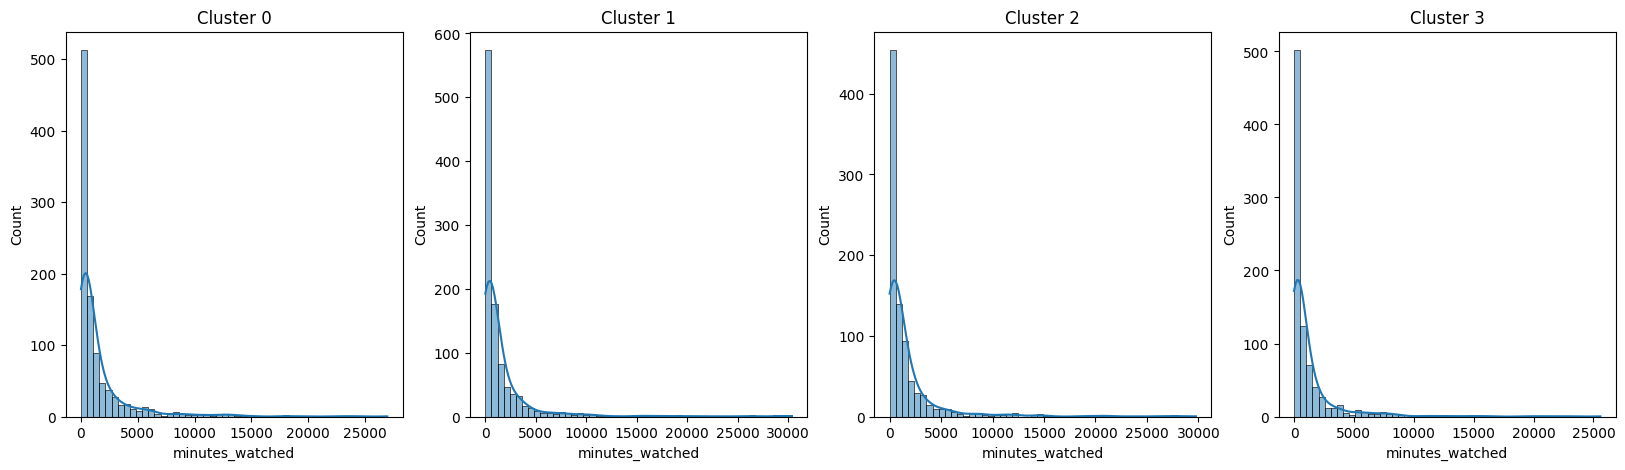

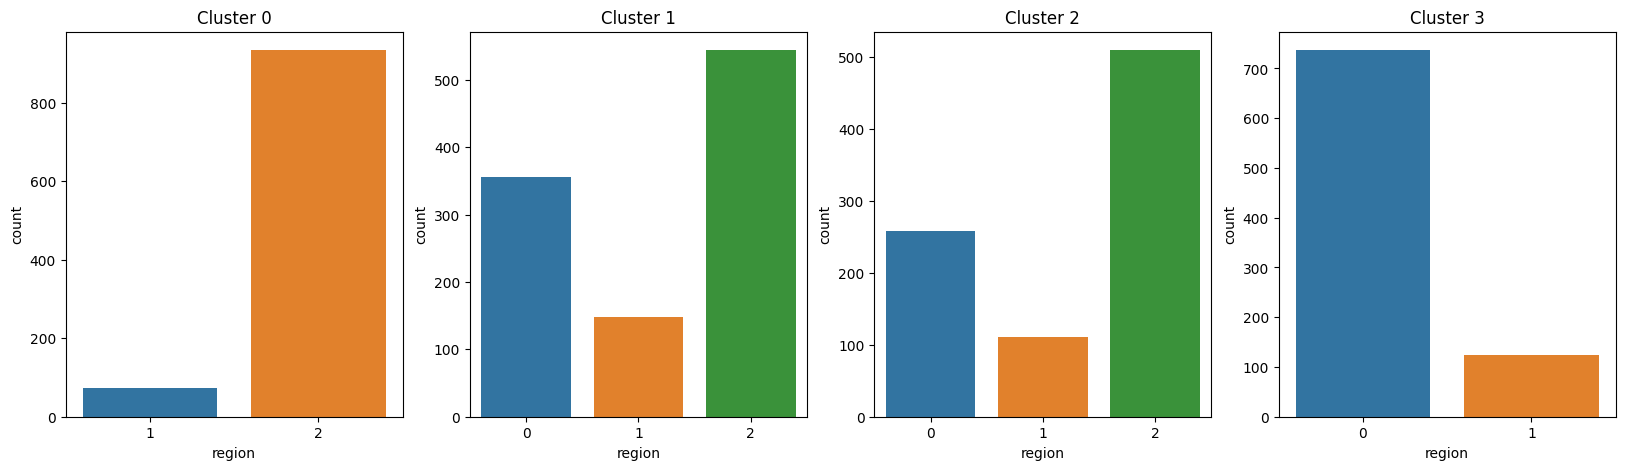

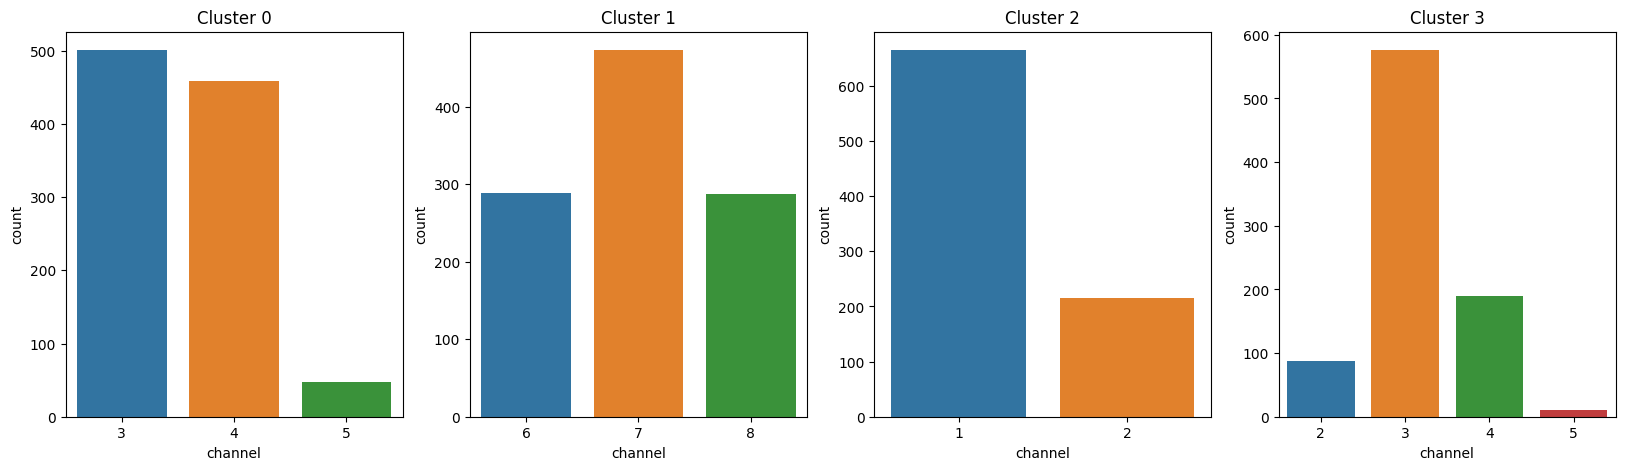

In [114]:
data_ck = clustersData(data, k)

clusterAnalysis(data_ck, k)

In [115]:
print({i+1 : label for i, label in enumerate(label_channel)})
print({i : label for i, label in enumerate(label_region)})

{1: 'Google', 2: 'Facebook', 3: 'Youtube', 4: 'LinkedIn', 5: 'Twitter', 6: 'Instagram', 7: 'Friend', 8: 'Other'}
{0: 'USA-Canada-UK-Australia', 1: 'EUW', 2: 'RestOfWorld'}


De este análisis podemos extraer algunas conclusiones:

*CLV y minutos vistos:*
    
    * El Cluster 0 tiene un patrón de CLV con un pico predominante en una zona de valores mas bajos.
    
    * Los Clusters 1 y 2 tienen patrones muy similares de CLV.
    
    * El Cluster 3 tiene patrones de CLV con un pico en valores mayores a los otros clusters.
    
    * Todos los clusters en términos de minutos mirados tienen patrones similares.

*Influencia de la región y el canal:*
    * La distribución por región muestra que ciertos clusters son dominantes en determinadas regiones. Por ejemplo, el Cluster 0 es dominante en la región Resto del mundo y no se encuentran en USA, el cluster 1 y 2 igualmente distribuidos en las 3 regiones con predominancia en Resto del mundo y USA mientras que el cluster 3 son clientes en su mayoría de USA-Canada-UK etc.

    * La distribución por canal indica que el cluster 0 son clientes que llegan principalmente por LinkedIn y Youtube. El cluster 1 son clientes que llegan principalmente por otros medios como Amigos, Otros o Instagram, esto quizas tiene algo que ver con el rango etario de este grupo, estaría bueno tener más información sobre esto. El cluster 2 son clientes que llegan principalmente por Google y Facebook. El cluster 3 son clientes que llegan principalmente por LinkedIn.

*Perfiles de clusters:*

    * Cluster 0: Usuarios principalmente de la región "Resto del mundo", interactuando mayormente a través de LinkedIn y YouTube, con CLV más bajo y minutos vistos similares a otros clusters.

    * Cluster 1: Usuarios diversos distribuidos en "Resto del mundo" y USA, llegando principalmente a través de Amigos, Otros o Instagram, con un rango de CLV similar a Cluster 2.

    * Cluster 2: Usuarios igualmente distribuidos en "Resto del mundo" y USA, interactuando principalmente a través de Google y Facebook, con un rango de CLV similar a Cluster 1.

    * Cluster 3: Usuarios predominantemente de USA, Canadá y UK, interactuando a través de LinkedIn, con un pico de CLV en valores más altos comparado con otros clusters.

*Recomendaciones
Marketing dirigido:*

    * Cluster 0: Enfocar los esfuerzos de marketing en la región "Resto del mundo" a través de LinkedIn y YouTube para maximizar el compromiso.

    * Cluster 1: Adaptar estrategias de marketing para "Resto del mundo" y USA, utilizando canales como Amigos, Otros o Instagram. Investigar más sobre el rango etario de este grupo para afinar 
    la estrategia.
    * Cluster 2: Concentrar los esfuerzos en "Resto del mundo" y USA, utilizando Google y Facebook como medios principales.

    * Cluster 3: Priorizar USA, Canadá y UK con marketing a través de LinkedIn para aumentar el compromiso.

Estrategias de compromiso:
    Considerar desarrollar estrategias para aumentar los minutos vistos en todos los clusters, dado que tienen patrones similares en este aspecto.
    Explorar las razones detrás del CLV más alto en el Cluster 3 y diseñar intervenciones para maximizar el valor de vida del cliente en todos los clusters, especialmente en aquellos con CLV más bajo como el Cluster 0.

### Hierarchical Clustering

Vamos a utilizar el método de clustering jerárquico para ver si podemos encontrar una relación más clara entre el canal de adquisición y el resto de las variables. Este método se resume en un dendrograma que nos muestra cómo se van uniendo los clusters, el dendrograma es una representación gráfica de la jerarquía de los clusters.

In [116]:
from sklearn.cluster import AgglomerativeClustering

hierarchical = AgglomerativeClustering(n_clusters=3)
data['hierarchical_cluster'] = hierarchical.fit_predict(data)

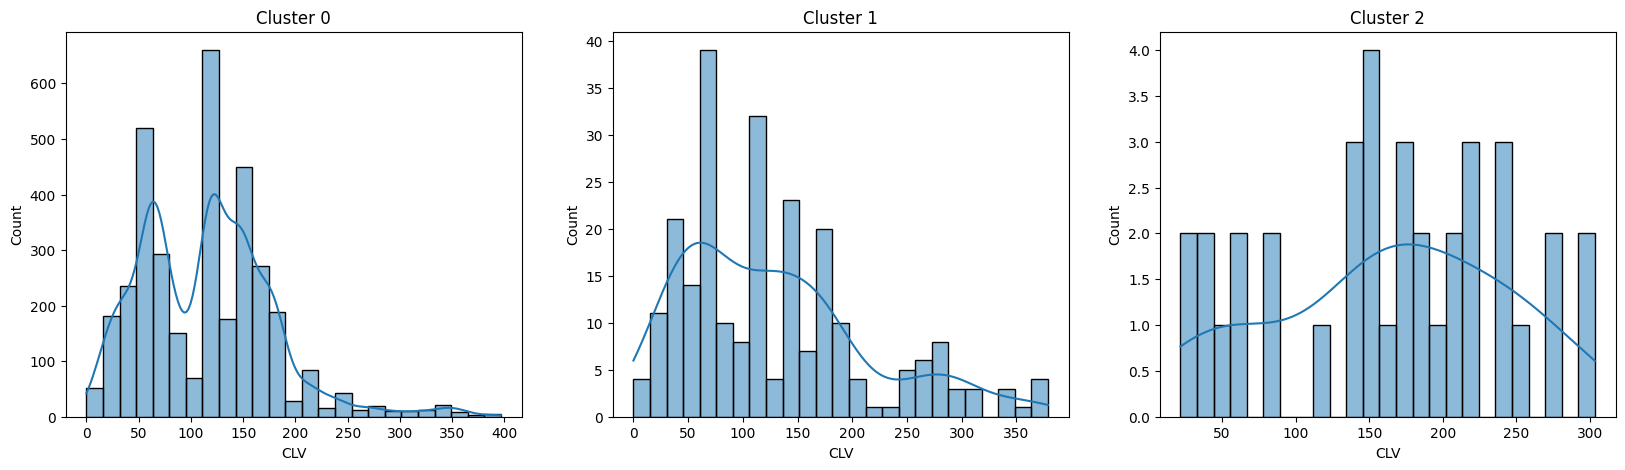

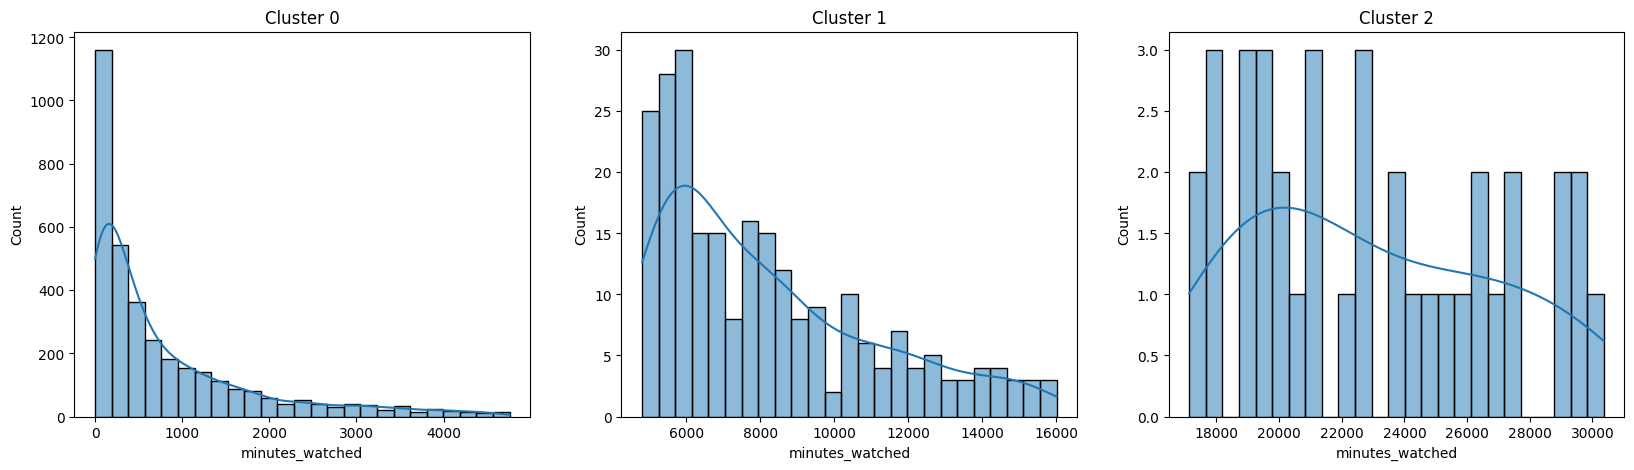

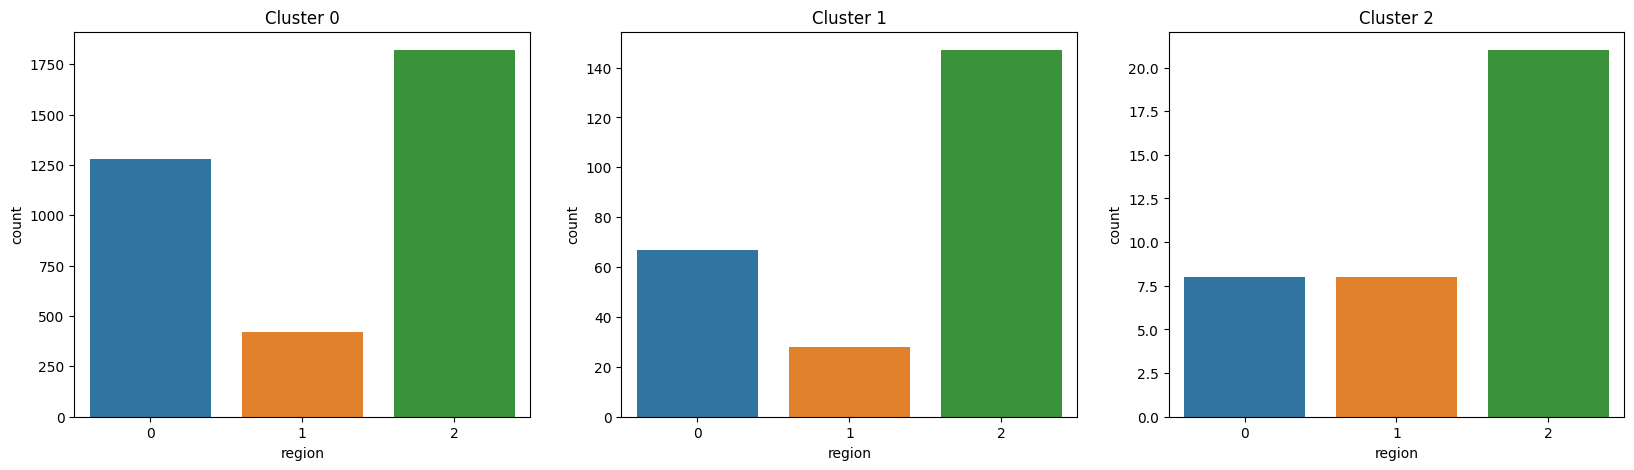

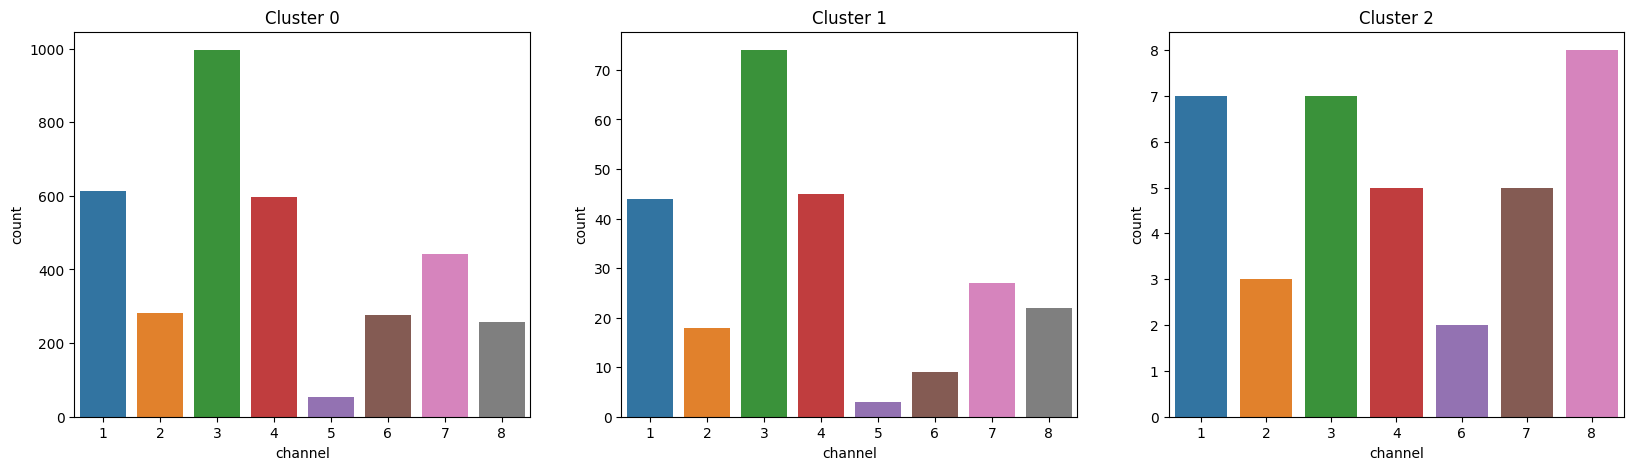

{1: 'Google', 2: 'Facebook', 3: 'Youtube', 4: 'LinkedIn', 5: 'Twitter', 6: 'Instagram', 7: 'Friend', 8: 'Other'}
{0: 'USA-Canada-UK-Australia', 1: 'EUW', 2: 'RestOfWorld'}


In [117]:
data_hc = data[data['hierarchical_cluster'] == 0]
data_hc1 = data[data['hierarchical_cluster'] == 1]
data_hc2 = data[data['hierarchical_cluster'] == 2]

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax = ax.ravel()

for i, cluster in enumerate([data_hc, data_hc1, data_hc2]):
    sns.histplot(cluster['CLV'], bins=25, kde=True, ax=ax[i])
    ax[i].set_title(f'Cluster {i}')

plt.show()

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax = ax.ravel()

for i, cluster in enumerate([data_hc, data_hc1, data_hc2]):
    sns.histplot(cluster['minutes_watched'], bins=25, kde=True, ax=ax[i])
    ax[i].set_title(f'Cluster {i}')

plt.show()

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax = ax.ravel()

for i, cluster in enumerate([data_hc, data_hc1, data_hc2]):
    sns.countplot(data = cluster, x = 'region', ax = ax[i])
    ax[i].set_title(f'Cluster {i}')

plt.show()

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax = ax.ravel()

for i, cluster in enumerate([data_hc, data_hc1, data_hc2]):
    sns.countplot(data = cluster, x = 'channel', ax = ax[i])
    ax[i].set_title(f'Cluster {i}')

plt.show()

print({i+1 : label for i, label in enumerate(label_channel)})
print({i : label for i, label in enumerate(label_region)})

Al no haber normalizado en el hierarchical clustering, claramente se separan clusters por minutos mirados y CLV los cuales parecen tener una correlación. En este caso elegímos únicamente 3 clusters. Como se ve en el cluster 0 tenemos usuarios los cuales cantidadad de minutos mirados entre 0 y 5000 y un CLV bajo, por otro lado no hay mucha distincción entre las regiones de proveniencia ni los canales.
En el cluster 1 tenemos usuarios con minutos mirados entre 5000 y 16000 pero no por esto una mayor media en la distribución de CLV, tampoco vemos una distinción clara entre las regiones de proveniencia ni los canales.
En el cluster 2 tenemos usuarios con minutos mirados entre 16000 y 30000 y un CLV alto, sin embargo no vemos una distinción clara entre las regiones de proveniencia ni los canales.